# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Problem understanding and possible solutions

Como falado acima, existem algumas premissas que precisam ser assumidas para identificarmos quando uma oferta é considerada como ***Sucesso*** ou ***Não-Sucesso***, essas premissas são:

1. Uma oferta somente é considerada como ***sucesso*** se seguir o seguinte fluxo:
        - Recebida -> Vista -> Completa

2. Caso contrário, uma oferta é assumida como ***não sucesso*** nas seguintes situações:
        - Recebida
        - Recebida -> Vista
        - Recebida -> Completa -> Vista
        - Recebida -> Completa
        
3. **Ofertas BOGO** são completadas no momento da compra, ou seja, se feito a transação minima dentro do prazo a oferta é completa.

4. **Ofertas DESCONTO** são completadas apenas quando a soma de transações atingem o minimo dentro do prazo limite

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import libraries

import pandas as pd
import numpy as np
import math, json, time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
def clean_portfolio(portfolio):
    '''
    Clean the portfolio dataset:
    - transform the "duration" column to hours
    - one-hot-enconde both channels and offer_type columns
    - rename the "id" column to "offer_id"
    
    INPUT:
    - the original portfolio dataset
    
    OUTPUT:
    - the cleaned portfolio dataset (portfolio_clean) 
    
    '''
    #create a copy
    portfolio_clean = portfolio.copy()
    
    portfolio_clean['offer_id2'] = np.where((portfolio_clean['offer_type'] == 'bogo'), 'Bogo', 
                              np.where((portfolio_clean['offer_type'] == 'discount'), 'Disc', 'Info'))

    portfolio_clean['offer_id2'] = portfolio_clean['offer_type'].map(str) + '-' + portfolio_clean['difficulty'].map(str) + '-' + portfolio_clean['duration'].map(str)
        
    #transform the "duration" column into hours
    portfolio_clean['duration'] = portfolio_clean['duration']*24
    
    #rename "id" column
    portfolio_clean = portfolio_clean.rename(columns={'id': 'offer_id'})

    #one-hot-encode the "channels" column
    portfolio_clean = portfolio_clean.drop('channels', axis = 1).join(portfolio_clean.channels.str.join('|').str.get_dummies())

    #one-hot-enconde the "offer_type" column
    offers_type = pd.get_dummies(portfolio_clean['offer_type'])

    #drop the old "offer_type" column and join dummies
    #portfolio_clean = portfolio_clean.drop('offer_type', axis = 1).join(offers_type)
    portfolio_clean = portfolio_clean.join(offers_type)
    
    return portfolio_clean
    

In [7]:
def clean_profile(profile):
    '''
    Clean the profile dataset:
    - change de dtype for the "became_member_on" to datetime
    - one-hot-enconde the "gender" column
    - rename the "id" column to "user_id"

    INPUT:
    - the original profile dataset
    
    OUTPUT:
    - the cleaned profile dataset (profile_clean) 
    
    '''
    #create a copy
    profile_clean = profile.copy()

    #change dtype on the "became_member_on" column to datetime
    profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'].astype(str), format='%Y%m%d')

    #one-hot-enconde the "gender" column
    genders = pd.get_dummies(profile_clean['gender'])
    
    #drop the "gender" column and join dummies
    #profile_clean = profile_clean.drop('gender', axis = 1).join(genders)
    profile_clean = profile_clean.join(genders)

    #rename the "id" column to "user_id"
    profile_clean = profile_clean.rename(columns={'id': 'user_id'})
    
    return profile_clean
    

In [8]:
def clean_transcript(transcript):
    '''
    Clean the transcript dataset:
    - normalize the "value" column
    - rename "person", "offer id" and "offer_id" columns
    - consolidate all offers ids into one column
    - drop the unnecessary columns 
    - drop the "reward" column --> it will be replaced after the final merge
    
    INPUT:
    - the original profile dataset
    
    OUTPUT:
    - the cleaned profile dataset
    
    '''
    #create a copy
    transcript_clean = transcript.copy()
    
    #normalizing dict row into columns
    transcript_clean = transcript_clean.join(pd.json_normalize(transcript_clean.value))  

    #rename columns
    transcript_clean = transcript_clean.rename(columns={'person': 'user_id',
                                                        'offer id': 'offer_id_received',
                                                        'offer_id': 'offer_id_completed'
                                                       }
                                              )
    #get the offer_id data from both columns
    transcript_clean['offer_id'] = np.where(transcript_clean['offer_id_received'].notna() == True,
                                            transcript_clean['offer_id_received'],
                                            transcript_clean['offer_id_completed']
                                           )
    
    #drop columns
    transcript_clean = transcript_clean.drop(columns=['value',
                                                      'reward',
                                                      'offer_id_received',
                                                      'offer_id_completed'],
                                             axis = 1
                                            )
    
    #one-hot-enconde the "event" column
    events = pd.get_dummies(transcript_clean['event'])

    #drop the "event" column and join dummies
    transcript_clean = transcript_clean.join(events)
    
    return transcript_clean


In [9]:
portfolio_df = clean_portfolio(portfolio)
transcript_df = clean_transcript(transcript)
profile_df = clean_profile(profile)

In [73]:
portfolio_df.head()

,reward,difficulty,duration,offer_type,offer_id,offer_id2,email,mobile,social,web,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10-7,1,1,1,0,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10-5,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,informational-0-4,1,1,0,1,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5-7,1,1,0,1,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-20-10,1,0,0,1,0,1,0


In [10]:
def final_merge(portfolio_df, transcript_df, profile_df):
    '''
    Merge all cleaned datasets into one
    
    INPUT:
    portfolio_df
    transcript_df
    profile_df
    
    OUTPUT:
    df
    
    '''
    
    #merge transcript and profile
    df = transcript_df.merge(profile_df, how='left', on='user_id')
    
    #merge transcript and portfolio
    df = df.merge(portfolio_df, how='left', on='offer_id')
       
    #sort dataframe by user_id and offer_id
    df = df.sort_values(['user_id', 'offer_id'], ascending=False)
    
    #drop all nan values
    df = df[df['income'].notna()]
    
    #drop old offer_id column and replace it
    df = df.drop(columns=['offer_id'])
    df = df.rename(columns={'offer_id2': 'offer_id'})
    
    return df
    

In [11]:
portfolio_df.sort_values(['offer_type', 'difficulty'], ascending=False).reset_index().drop('index', axis=1).head()

,reward,difficulty,duration,offer_type,offer_id,offer_id2,email,mobile,social,web,bogo,discount,informational
0,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,informational-0-4,1,1,0,1,0,0,1
1,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,informational-0-3,1,1,1,0,0,0,1
2,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-20-10,1,0,0,1,0,1,0
3,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,discount-10-10,1,1,1,1,0,1,0
4,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,discount-10-7,1,1,0,1,0,1,0


In [12]:
transcript_df.head()

,user_id,event,time,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [80]:
profile_df.head(10)

,gender,age,user_id,became_member_on,income,F,M,O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,0,0,0
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,0,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN,0,0,0


In [14]:
df = final_merge(portfolio_df, transcript_df, profile_df)

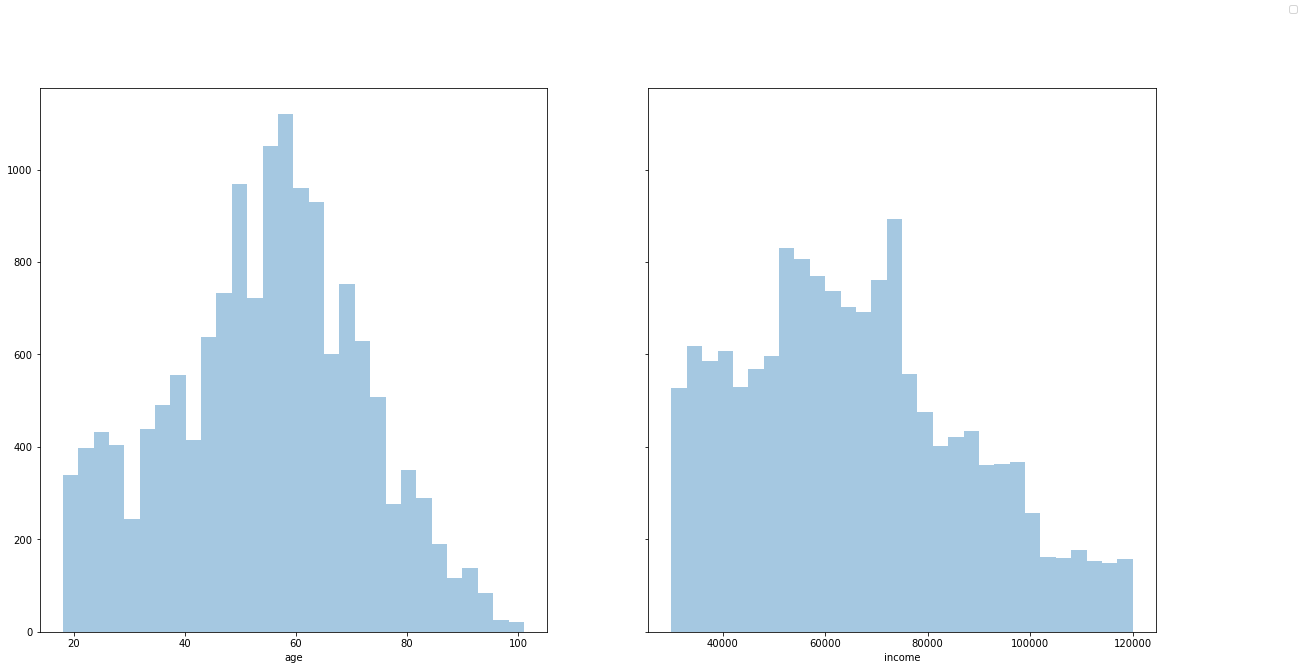

In [16]:
#users age and income
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(20,10)
fig.legend(['abacaxi', 'banana'])

#plot income histogram
income_hist = df.groupby(['user_id'])['age'].mean()
sns.distplot(income_hist,ax=ax[0], kde=False, bins=30);

#plot income histogram
income_hist = df.groupby(['user_id'])['income'].mean()
sns.distplot(income_hist, ax=ax[1], kde=False, bins=30);

plt.savefig('./figures/user_demograph.png')

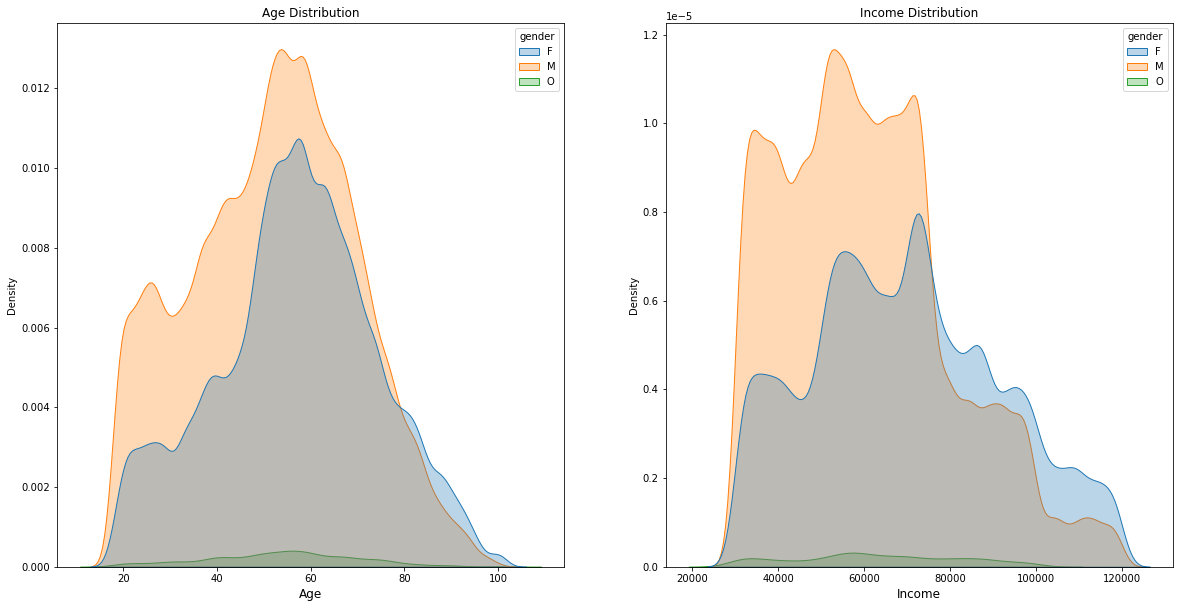

In [17]:
#age and income distribuction by gender
fig, ax = plt.subplots(1,2)

fig.set_size_inches(20,10)


sns.kdeplot(data=df, x='age', hue='gender', fill=True, ax=ax[0], alpha=0.3)
ax[0].set_title('Age Distribution', fontsize=12)
ax[0].set_xlabel('Age', fontsize=12)

sns.kdeplot(data=df, x='income', hue='gender', fill=True, ax=ax[1], alpha=0.3)
ax[1].set_title('Income Distribution', fontsize=12)
ax[1].set_xlabel('Income', fontsize=12)

plt.savefig('./figures/gender_distribuition.png')

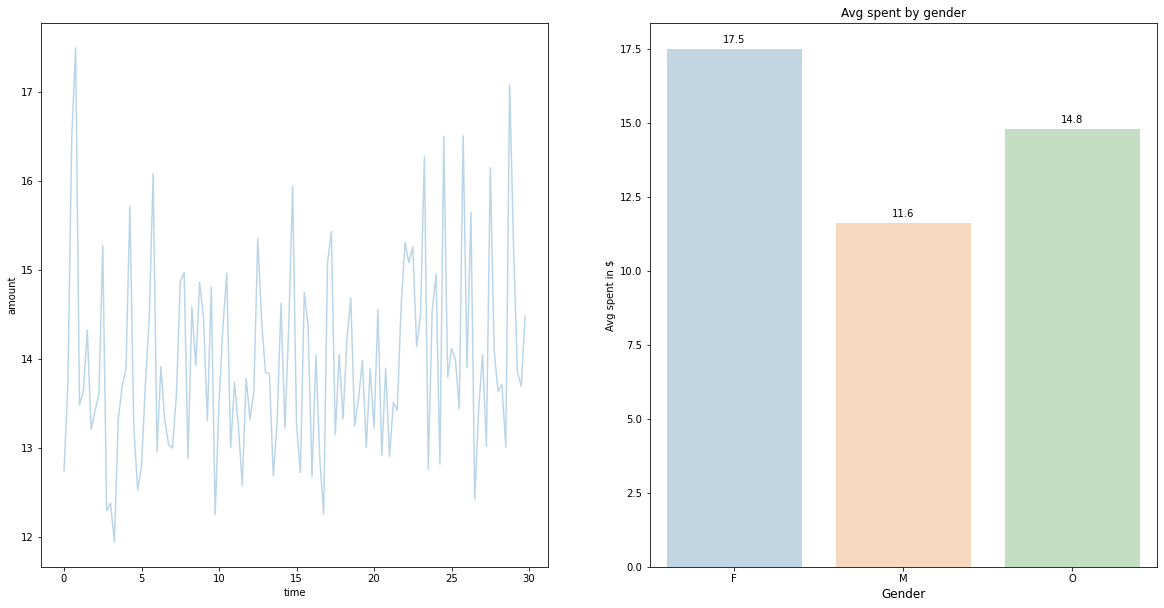

In [18]:
#avg amount spent per day and gender
transaction_per_day = df[df['transaction'] == 1].groupby('time', as_index=False)['amount'].mean()
transaction_per_day['time'] = transaction_per_day['time']/24

fig, ax = plt.subplots(1,2)

fig.set_size_inches(20,10)

sns.lineplot(data=transaction_per_day, x='time', y='amount', ax=ax[0], alpha=.3)


splot = sns.barplot(data=df, x='gender', y='amount', ax=ax[1], alpha=.3, ci=False)
ax[1].set_title('Avg spent by gender', fontsize=12)
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel('Avg spent in $')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

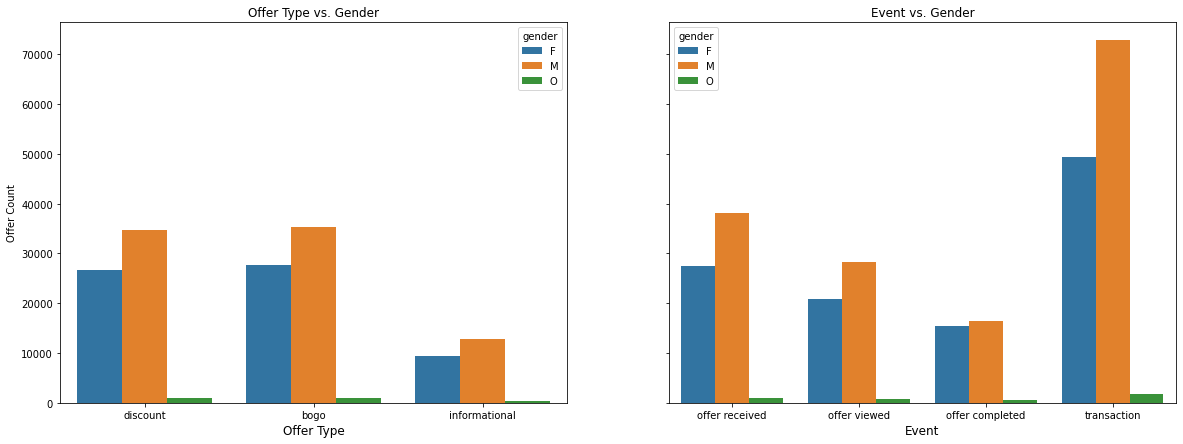

In [19]:
#how offers were divided between users for each offer_type and how they react to then
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(20,7)

sns.countplot(data=df, x='offer_type', hue='gender', ax=ax[0])
ax[0].set_title('Offer Type vs. Gender', fontsize=12)
ax[0].set_xlabel('Offer Type', fontsize=12)
ax[0].set_ylabel('Offer Count')

sns.countplot(data=df, x='event', hue='gender', ax=ax[1])
ax[1].set_title('Event vs. Gender', fontsize=12)
ax[1].set_xlabel('Event', fontsize=12)
ax[1].set_ylabel(' ')

plt.savefig('./figures/offer_vs_gender.png')

In [20]:
df.groupby('event', as_index=False)['user_id'].count()

,event,user_id
0,offer completed,32444
1,offer received,66501
2,offer viewed,49860
3,transaction,123957


# Identificando o sucesso dos usuários / ofertas

#### A seguir é feito uma limpeza no banco de dados para identificar as ofertas que foram completadas com sucesso para os tipos DESCONTO e BOGO, também é calculado o valor que essa ofertas arrecadam.

##### Premissas:
1. Uma oferta somente é considerada como ***sucesso*** se seguir o seguinte fluxo:
        - Recebida -> Vista -> Completa

2. Todo o restante é considerando como ***não sucesso***:
        - Recebida
        - Recebida -> Vista
        - Recebida -> Completa -> Vista
        - Recebida -> Completa
        
3. Ofertas BOGO são completadas no momento da compra, ou seja, se feito a transação minima dentro do prazo a oferta é completa.
4. Ofertas DESCONTO são completadas apenas quando a soma de transações atingem o minimo dentro do prazo limite



In [21]:
def bogo_offers(df=df):
    
    '''
    Identifies bogo offers that were successful and unsuccessful
    
    INPUT:
    df - cleaned and merged dataframe
    
    OUTPUT:
    bogo_sucess - all sucessful bogo offers
    bogo_not_sucess - all unsucessful bogo offers
    bogo_offers - merged df with successful and not successful offers
    '''

    #df with bogo offers and transactions
    bogo = df[(df['offer_type'] == 'bogo')]
    
    #offset just the necessary columns
    bogo = bogo[['user_id', 'duration', 'offer received', 'offer viewed', 'offer completed',
                 'offer_type', 'offer_id', 'time', 'difficulty', 'reward', 'F', 'M', 'O',
                 'age', 'gender', 'income', 'became_member_on',
                 'event', 'email', 'mobile', 'web', 'social']]
    
    #replace white space for underline in the column name
    bogo.columns = bogo.columns.str.strip().str.replace('\s+', '_')
    
    #sort values by users and time (this make every transaction to be below the completed offer)
    bogo = bogo.sort_values(['user_id', 'time'], ascending=True)

    #create a time_limit column
    bogo['time_limit'] = bogo['time'] + bogo['duration']

    #create a unique column for suport
    bogo['conc'] = bogo['user_id'] + bogo['offer_id']

    #In order to achieve the offer, the user must follow the sequence:
    #received -> viewed -> completed
    
    #identify if is a received offer row
    #check if its the same user+offer_id on row below
    #check if its a offer_viewed
    #set the column "offer_view" in the row to 1
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-1) ) &
                ( bogo.offer_viewed.shift(-1) == 1 ),
                ['offer_viewed'] ] = bogo.offer_viewed.shift(-1)

    #time_viewed
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-1) ) &
                ( bogo.offer_viewed.shift(-1) == 1 ),
                ['time_viewed'] ] = bogo.time.shift(-1)

    #identify if is a received offer row
    #check if its the same user+offer_id on 2 rows below
    #check if its a offer_completed
    #set the column "offer_completed" in the row to 1
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-2) ) &
                ( bogo.offer_completed.shift(-2) == 1 ),
                ['offer_completed'] ] = bogo.offer_completed.shift(-2)

    #time_completed
    bogo.loc[ ( bogo['offer_received'] == 1 ) & 
                ( bogo.conc.shift(0) == bogo.conc.shift(-2) ) &
                ( bogo.offer_completed.shift(-2) == 1 ),
                ['time_completed'] ] = bogo.time.shift(-2)

    #create a empty amount column
    bogo['amount'] = 0
    
    #create a 'True' and 'False' for 'sucess'    
    bogo['sucess'] = np.where(((bogo['offer_received'] == 1) & 
                               (bogo['offer_viewed'] == 1) & 
                               (bogo['offer_completed'] == 1)
                              ), 1, 0
                             )   
    
    #subset just user+offer with received, view and completed equals to 1
    bogo_not_sucess = bogo[bogo['sucess'] == 0]
    bogo_sucess = bogo[bogo['sucess'] == 1]
    
    #create new df only with transactions
    transactions = df[df['event'] == 'transaction']

    #offset just necessary columns
    transactions = transactions[['user_id', 'time', 'amount']]

    #find common users between both dataframes
    common_users = np.intersect1d(bogo_sucess['user_id'], transactions['user_id'])

    #select only transactions for users that received, viewed and completed offers
    transactions = transactions[transactions.user_id.isin(common_users)]

    #reset index
    bogo_sucess = bogo_sucess.reset_index().drop('index', axis = 1)
    bogo_sucess.index = np.arange(1,len(bogo_sucess)+1)

    #for all users
    for index in bogo_sucess.index:
        #Identify the same user in both dataframes +
        #check if the transaction was made between the time received and time completed
        #sum the amount and save in the "amount" column
        bogo_sucess['amount'][index] = transactions.loc[ (transactions.user_id == bogo_sucess['user_id'][index]) & 
                                        (transactions.time == bogo_sucess['time_completed'][index])        
                                        ]['amount'].sum()
                
                
    bogo_sucess['conc1'] = bogo_sucess['conc'] + 'offer viewed' + bogo_sucess['time_viewed'].map(str)
    bogo_sucess['conc2'] = bogo_sucess['conc'] + 'offer completed' + bogo_sucess['time_completed'].map(str)

    bogo_not_sucess['time'] = bogo_not_sucess['time'].astype('float64')
    bogo_not_sucess['conc1'] = bogo_not_sucess['conc'] + bogo_not_sucess['event'] + bogo_not_sucess['time'].map(str)
    bogo_not_sucess['conc2'] = bogo_not_sucess['conc'] + bogo_not_sucess['event'] + bogo_not_sucess['time'].map(str)

    common = np.intersect1d(bogo_sucess['conc1'], bogo_not_sucess['conc1'])
    common2 = np.intersect1d(bogo_sucess['conc2'], bogo_not_sucess['conc2'])
    
    bogo_not_sucess  = bogo_not_sucess[~bogo_not_sucess.conc1.isin(common)]
    bogo_not_sucess  = bogo_not_sucess[~bogo_not_sucess.conc2.isin(common2)]
    
    bogo_not_sucess = bogo_not_sucess[bogo_not_sucess['offer_received'] == 1]
              
    #Concat both dfs
    bogo_offers = pd.concat([bogo_sucess, bogo_not_sucess])

    return bogo_sucess, bogo_not_sucess, bogo_offers

In [22]:
def discount_offers(df=df):
    
    '''
    Identifies discount offers that were successful and unsuccessful
    
    INPUT:
    df - cleaned and merged dataframe
    
    OUTPUT:
    discount_sucess - all sucessful discount offers
    discount_not_sucess - all unsucessful discount offers
    discount_offers - merged df with successful and not successful offers
    '''
       
    #select just discount offers   
    discount = df[(df['offer_type'] == 'discount')]
                         
    #offset just the necessary columns
    discount = discount[['user_id', 'duration', 'offer received', 'offer viewed', 'offer completed',
                         'offer_type', 'offer_id', 'time', 'difficulty', 'reward', 'F', 'M', 'O',
                         'age', 'gender', 'income', 'became_member_on',
                         'event', 'email', 'mobile', 'web', 'social']]
    
    #replace white space for underline in the column name
    discount.columns = discount.columns.str.strip().str.replace('\s+', '_')
       
    #sort values
    discount = discount.sort_values(['user_id', 'time'], ascending=True)
    
    #create a limit column if offer received = True
    discount['time_limit'] = discount['time'] + discount['duration']
                         
    #create a unique column for futher aux
    discount['conc'] = discount['user_id'] + discount['offer_id']
    
    #In order to achieve the offer, the user must follow the sequence:
    #received -> viewed -> completed
    
    #identify if is a received offer row
    #check if its the same user+offer_id on row below
    #check if its a offer_viewed
    #set the column "offer_view" in the row to 1
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-1) ) &
               ( discount.offer_viewed.shift(-1) == 1 ),
               ['offer_viewed'] ] = discount.offer_viewed.shift(-1)

    #time_viewed
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-1) ) &
               ( discount.offer_viewed.shift(-1) == 1 ),
               ['time_viewed'] ] = discount.time.shift(-1)

    #identify if is a received offer row
    #check if its the same user+offer_id on 2 rows below
    #check if its a offer_completed
    #set the column "offer_completed" in the row to 1
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-2) ) &
               ( discount.offer_completed.shift(-2) == 1 ),
               ['offer_completed'] ] = discount.offer_completed.shift(-2)

    #time_completed
    discount.loc[ ( discount['offer_received'] == 1 ) & 
               ( discount.conc.shift(0) == discount.conc.shift(-2) ) &
               ( discount.offer_completed.shift(-2) == 1 ),
               ['time_completed'] ] = discount.time.shift(-2)
    
    #create a empty amount column
    discount['amount'] = 0
    
    #create a 'True' and 'False' for 'sucess'    
    discount['sucess'] = np.where(((discount['offer_received'] == 1) & 
                                   (discount['offer_viewed'] == 1) & 
                                   (discount['offer_completed'] == 1)
                                  ), 1, 0
                                 )  
       
    #subset just user+offer with received, view and completed equals to 1
    discount_not_sucess = discount[discount['sucess'] == 0]
    discount_sucess = discount[discount['sucess'] == 1]
    
    #create new df only with transactions
    transactions = df[df['event'] == 'transaction']
    
    #offset just necessary columns
    transactions = transactions[['user_id', 'time', 'amount']]
    
    #find common users between both dataframes
    common_users = np.intersect1d(discount['user_id'], transactions['user_id'])
    
    #select only transactions for users that received, viewed and completed offers
    transactions  = transactions[transactions.user_id.isin(common_users)]
    
    #reset index
    discount = discount.reset_index().drop('index', axis = 1)
    discount.index = np.arange(0,len(discount))
                             
    #for all users 
    for index in discount.index:
        #Identify the same user in both dataframes +
        #check if the transaction was made between the time received and time completed
        #sum the amount and save in the "amount" column
        discount['amount'][index] = transactions.loc[ (transactions.user_id == discount['user_id'][index]) & 
                                        (transactions.time >= discount['time'][index]) &
                                        (transactions.time <= discount['time_completed'][index])
        
                                        ]['amount'].sum()
    
    discount_sucess['conc1'] = discount_sucess['conc'] + 'offer viewed' + discount_sucess['time_viewed'].map(str)
    discount_sucess['conc2'] = discount_sucess['conc'] + 'offer completed' + discount_sucess['time_completed'].map(str)

    discount_not_sucess['time'] = discount_not_sucess['time'].astype('float64')
    discount_not_sucess['conc1'] = discount_not_sucess['conc'] + discount_not_sucess['event'] + discount_not_sucess['time'].map(str)
    discount_not_sucess['conc2'] = discount_not_sucess['conc'] + discount_not_sucess['event'] + discount_not_sucess['time'].map(str)

    common = np.intersect1d(discount_sucess['conc1'], discount_not_sucess['conc1'])
    common2 = np.intersect1d(discount_sucess['conc2'], discount_not_sucess['conc2'])
    
    discount_not_sucess  = discount_not_sucess[~discount_not_sucess.conc1.isin(common)]
    discount_not_sucess  = discount_not_sucess[~discount_not_sucess.conc2.isin(common2)]
    
    discount_not_sucess = discount_not_sucess[discount_not_sucess['offer_received'] == 1]
    
    #Concat both dfs
    discount_offers = pd.concat([discount_sucess, discount_not_sucess])
        
    return discount_sucess, discount_not_sucess, discount_offers

In [23]:
discount_sucess, discount_not_sucess, discount_offers = discount_offers()

In [24]:
bogo_sucess, bogo_not_sucess, bogo_offers = bogo_offers()

In [25]:
final_df = pd.concat([discount_offers, bogo_offers])

In [26]:
def ROI(discount_sucess=discount_sucess, bogo_sucess=bogo_sucess):
    
    #count each offer_id
    ROI_discount = discount_sucess.groupby('offer_id', as_index=False)['amount', 'difficulty'].sum()
    ROI_bogo = bogo_sucess.groupby('offer_id', as_index=False)['amount', 'difficulty'].sum()
    ROI = pd.concat([ROI_discount, ROI_bogo])
    
    #calculate ROI
    ROI['ROI'] = (ROI['amount']-ROI['difficulty'])/ROI['difficulty']
     
    return ROI

# MODELO DE CLASSIFICAÇÃO

Iniciei olhando a matriz de correlação entre as principais features da matriz final. Algumas foram retiradas, pois foi identificado que participavam em 100% das situações - ***offer_received e email***.

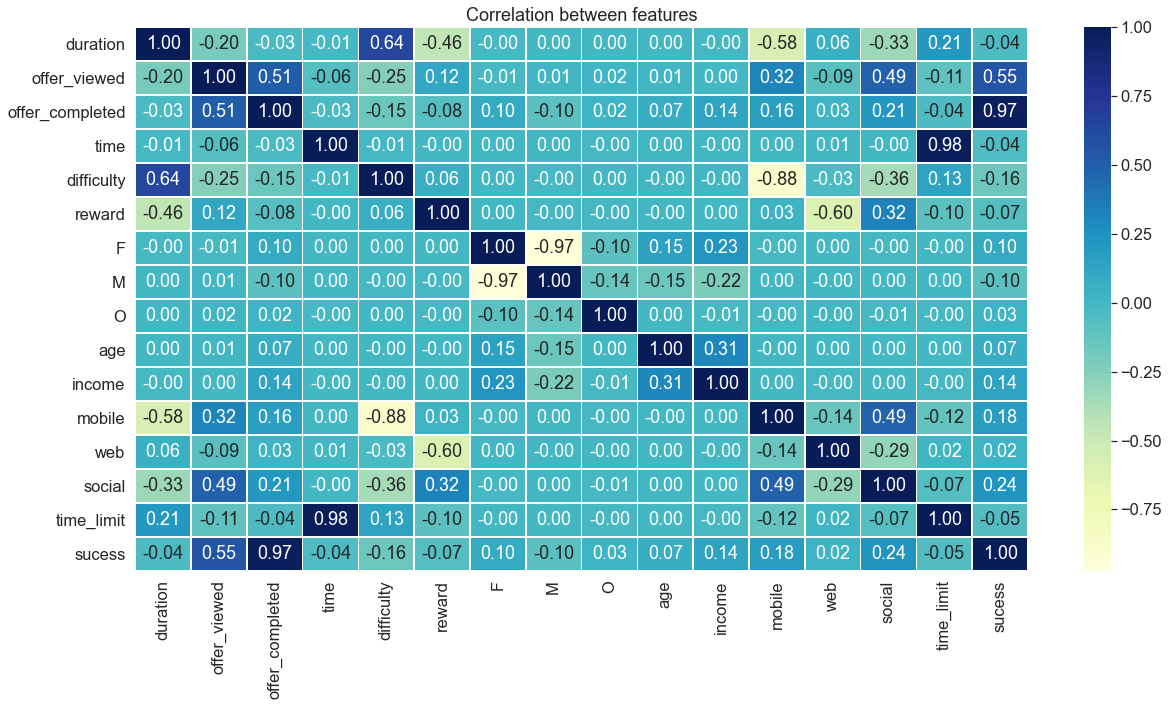

In [62]:
correlacao = final_df[['user_id', 'duration', 'offer_viewed',
                       'offer_completed', 'offer_type', 'offer_id', 'time', 'difficulty',
                        'reward', 'F', 'M', 'O', 'age', 'income', 'became_member_on', 'event',
                        'mobile', 'web', 'social', 'time_limit', 'sucess']]

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)

sns.heatmap(correlacao.corr(),
            annot = True,
            fmt = '.2f',
            linewidths=.8,
            cmap='YlGnBu')

plt.title('Correlation between features')

plt.savefig('./figures/correlation_matrix.png')

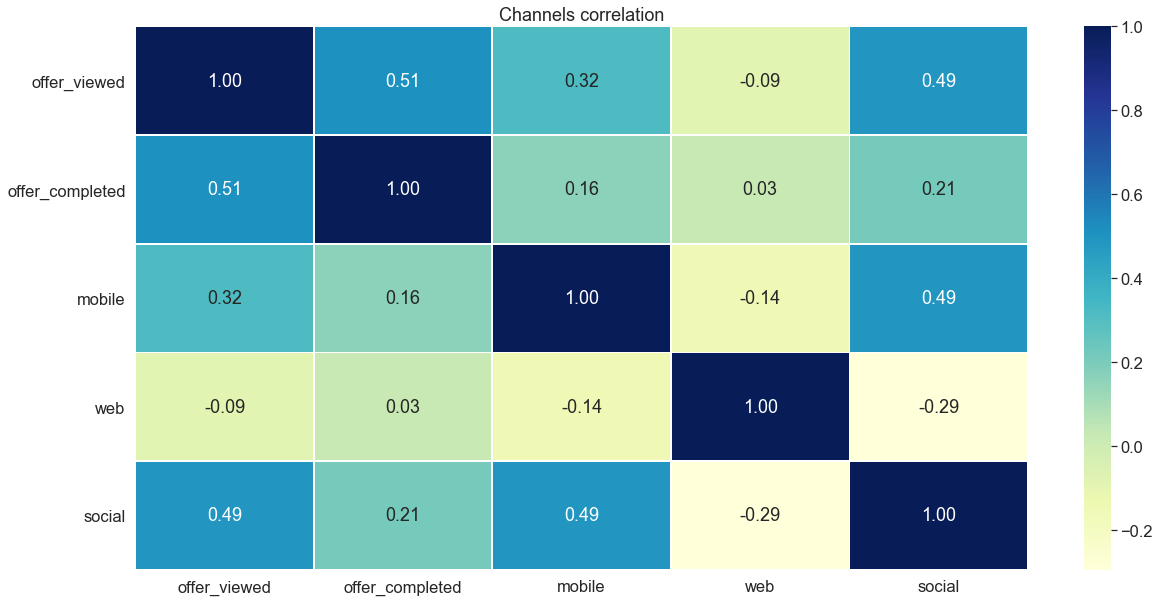

In [63]:
correlacao = final_df[['offer_viewed', 'offer_completed',
                        'mobile', 'web', 'social']]

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
sns.heatmap(correlacao.corr(),
            annot = True,
            fmt = '.2f',
            linewidths=.8,
            cmap='YlGnBu')

plt.title('Channels correlation')

plt.savefig('./figures/correlation_channels.png')

In [28]:
def classification_model(df, target, model):
    '''
    Builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable ('sucess' column)
    model - the model used for prediction
    
    OUTPUT:
    model - the classification model
    
    '''
    #selecting the features do analyse   
    X = df[['offer_type', 'duration', 'time', 'difficulty', 'reward',
            'age', 'F', 'M', 'O', 'income',
            'web', 'mobile', 'social']]
    
    #create dummies for all offers
    offer_dummies = pd.get_dummies(X['offer_type'])
    
    #insert the offers dummies and drop the offer_type column
    X = pd.concat([X.drop('offer_type', axis=1), offer_dummies], axis=1)
    
    #set the target column - it should be the 'Sucess'
    y = df[target]
    
    #split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    #select the model, fit and predict
    model = model #variable for the model
    model.fit(X_train, y_train) #fit the model
    y_pred = model.predict(X_test) #predict the model
    print(classification_report(y_test, y_pred))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, y_pred)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
       
    #plot feature_importances
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plot = sns.barplot(x=importances, y=X.columns, orient='h').set_title('Features Importance')    
    
    return model, plot

#### Os seguintes modelos foram testados:

1. RandomForestClassifier
2. GradientBoostingClassifier
3. AdaBoostClassifier
4. DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      9502
           1       0.53      0.48      0.50      6459

    accuracy                           0.62     15961
   macro avg       0.60      0.60      0.60     15961
weighted avg       0.61      0.62      0.62     15961

Overall model accuracy:	 0.6186955704529792
Train ROC AUC score:	 0.9992068777158848
Test ROC AUC score:	 0.6491679345608551


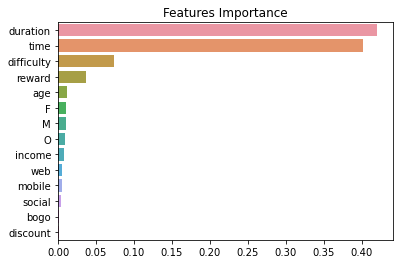

In [29]:
#execute the classification model with the RandomForestClassifier
rfc = classification_model(final_df, 'sucess', RandomForestClassifier(random_state=42))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9502
           1       0.61      0.48      0.54      6459

    accuracy                           0.67     15961
   macro avg       0.65      0.64      0.64     15961
weighted avg       0.66      0.67      0.66     15961

Overall model accuracy:	 0.6666875509053317
Train ROC AUC score:	 0.7188207143274103
Test ROC AUC score:	 0.7163737809095136


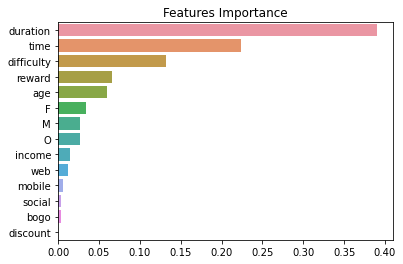

In [30]:
#execute the classification model with the GradientBoostingClassifier
gbc = classification_model(final_df, 'sucess', GradientBoostingClassifier(random_state=42))

In [31]:
#get model params keys
model = GradientBoostingClassifier(random_state=42)
model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      9502
           1       0.62      0.43      0.51      6459

    accuracy                           0.66     15961
   macro avg       0.65      0.63      0.63     15961
weighted avg       0.66      0.66      0.65     15961

Overall model accuracy:	 0.6632416515255937
Train ROC AUC score:	 0.704479002299589
Test ROC AUC score:	 0.7080889889495807


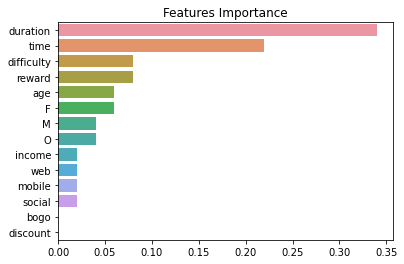

In [32]:
#execute the classification model with the AdaBoostClassifier
abc = classification_model(final_df, 'sucess', AdaBoostClassifier(random_state=42))

In [33]:
#get model params keys
model = AdaBoostClassifier(random_state=42)
model.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

              precision    recall  f1-score   support

           0       0.65      0.66      0.66      9502
           1       0.49      0.48      0.48      6459

    accuracy                           0.59     15961
   macro avg       0.57      0.57      0.57     15961
weighted avg       0.59      0.59      0.59     15961

Overall model accuracy:	 0.5875571706033457
Train ROC AUC score:	 0.9993404432160612
Test ROC AUC score:	 0.5709826361634283


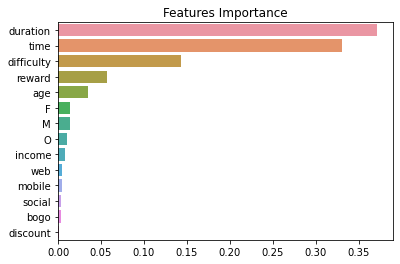

In [34]:
#execute the classification model with the DecisionTreeClassifier
dtc = classification_model(final_df, 'sucess', DecisionTreeClassifier(random_state=42))

### Como os modelos com melhores resultados foram: AdaBoostClassifier & GradientBoostingClassifier. E coincidentemente eles possuem 2 parametros similares, optei por identificar os melhores parâmetros nesses dois modelos.

In [94]:
parameters_abc = {'n_estimators': [500, 1000, 1500],
                  'learning_rate': [0.1, 0.2, 0.5],
                  'algorithm': ['SAMME', 'SAMME.R'],
                 }

parameters_gbc = {'n_estimators': [500, 1000, 1500],
                  'learning_rate': [0.1, 0.2, 0.5],
                  'min_samples_split': [2, 3, 4],
                 }


def model_best_params(df, target, model, parameters):
    '''
    Find the best parameters for the model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable ('sucess' column)
    parameters - dict with the model parameters
    
    OUTPUT:
    model - the classification model with best parameters
    '''
    
    #selecting the features do analyse   
    X = df[['offer_type', 'duration', 'time', 'difficulty', 'reward',
            'age', 'F', 'M', 'O', 'income',
            'web', 'mobile', 'social']]
    
    #create dummies for all offers
    offer_dummies = pd.get_dummies(X['offer_type'])
    
    #insert the offers dummies and drop the offer_type column
    X = pd.concat([X.drop('offer_type', axis=1), offer_dummies], axis=1)
    
    #set the target column - it should be the 'Sucess'
    y = df[target]
    
    #split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    #select the model, parameters and setting the grid
    model = model
    parameters = parameters
    
    grid = GridSearchCV(estimator=model,
                        param_grid=parameters,
                        cv=3,
                        verbose=3,
                        n_jobs=-1)
    
    #fit and predict
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, y_pred)))
    print('Best Params: ', grid.best_params_)
    
    return model

In [92]:
#find best parameters for adaboost classifier
model_best_params(final_df, 'sucess', AdaBoostClassifier(random_state=42), parameters_abc)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
              precision    recall  f1-score   support

           0       0.68      0.82      0.74      9502
           1       0.62      0.44      0.51      6459

    accuracy                           0.66     15961
   macro avg       0.65      0.63      0.63     15961
weighted avg       0.66      0.66      0.65     15961

Overall model accuracy:	 0.6633669569575841
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 1500}


AdaBoostClassifier(random_state=42)

In [95]:
#find best parameters for gradient classifier
model_best_params(final_df, 'sucess', GradientBoostingClassifier(random_state=42), parameters_gbc)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9502
           1       0.61      0.49      0.54      6459

    accuracy                           0.67     15961
   macro avg       0.65      0.64      0.64     15961
weighted avg       0.66      0.67      0.66     15961

Overall model accuracy:	 0.6659357183133889
Best Params:  {'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 500}


GradientBoostingClassifier(random_state=42)

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      9502
           1       0.62      0.44      0.51      6459

    accuracy                           0.66     15961
   macro avg       0.65      0.63      0.63     15961
weighted avg       0.66      0.66      0.65     15961

Overall model accuracy:	 0.6633669569575841
Train ROC AUC score:	 0.7065750067372544
Test ROC AUC score:	 0.7082652297449037


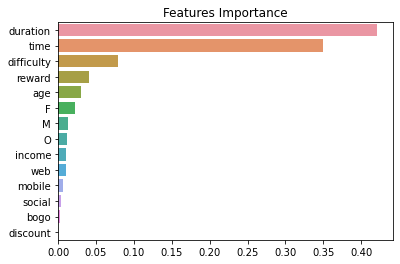

In [38]:
#execute the classification model with the AdaBoostClassifier using the best parameters
abc_opt = classification_model(final_df, 'sucess', AdaBoostClassifier(n_estimators=1500,
                                                                      learning_rate=.2,
                                                                      random_state=42))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9502
           1       0.61      0.49      0.54      6459

    accuracy                           0.67     15961
   macro avg       0.65      0.64      0.64     15961
weighted avg       0.66      0.67      0.66     15961

Overall model accuracy:	 0.6659357183133889
Train ROC AUC score:	 0.7344756011581727
Test ROC AUC score:	 0.7158276731467034


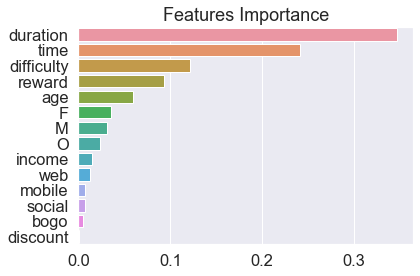

In [96]:
#execute the classification model with the GradientBoostingClassifier using the best parameters
gbc_opt = classification_model(final_df, 'sucess', GradientBoostingClassifier(min_samples_split=2,
                                                                              n_estimators=500,
                                                                              learning_rate=.1,
                                                                              random_state=42))

In [40]:
final_df.groupby('offer_id', as_index=False)['offer_received', 'offer_viewed', 'offer_completed', 'sucess'].sum().sort_values('offer_id', ascending=False)

,offer_id,offer_received,offer_viewed,offer_completed,sucess
7,discount-7-7,6655.0,5769.0,3858.0,3812
6,discount-20-10,6726.0,1949.0,1341.0,1124
5,discount-10-7,6631.0,2917.0,2078.0,1898
4,discount-10-10,6652.0,5887.0,4028.0,4000
3,bogo-5-7,6685.0,2916.0,2081.0,1931
2,bogo-5-5,6576.0,5712.0,3310.0,3288
1,bogo-10-7,6683.0,5264.0,2509.0,2450
0,bogo-10-5,6593.0,5842.0,2598.0,2566


In [41]:
offer_sucess = final_df.groupby('offer_id', as_index=False)['sucess'].mean().sort_values('sucess', ascending=False)
gender_sucess = final_df.groupby('gender', as_index=False)['sucess'].mean().sort_values('sucess', ascending=False)
gender_offer_sucess = final_df.groupby(['gender', 'offer_id'], as_index=False)['sucess'].mean().sort_values('sucess', ascending=False)

In [42]:
gender_offer_sucess = gender_offer_sucess[gender_offer_sucess['gender'] != 'O']
gender_offer_sucess

,gender,offer_id,sucess
4,F,discount-10-10,0.668027
7,F,discount-7-7,0.622884
2,F,bogo-5-5,0.563028
12,M,discount-10-10,0.553516
15,M,discount-7-7,0.536281
0,F,bogo-10-5,0.500183
10,M,bogo-5-5,0.450226
1,F,bogo-10-7,0.446182
3,F,bogo-5-7,0.320202
5,F,discount-10-7,0.311950


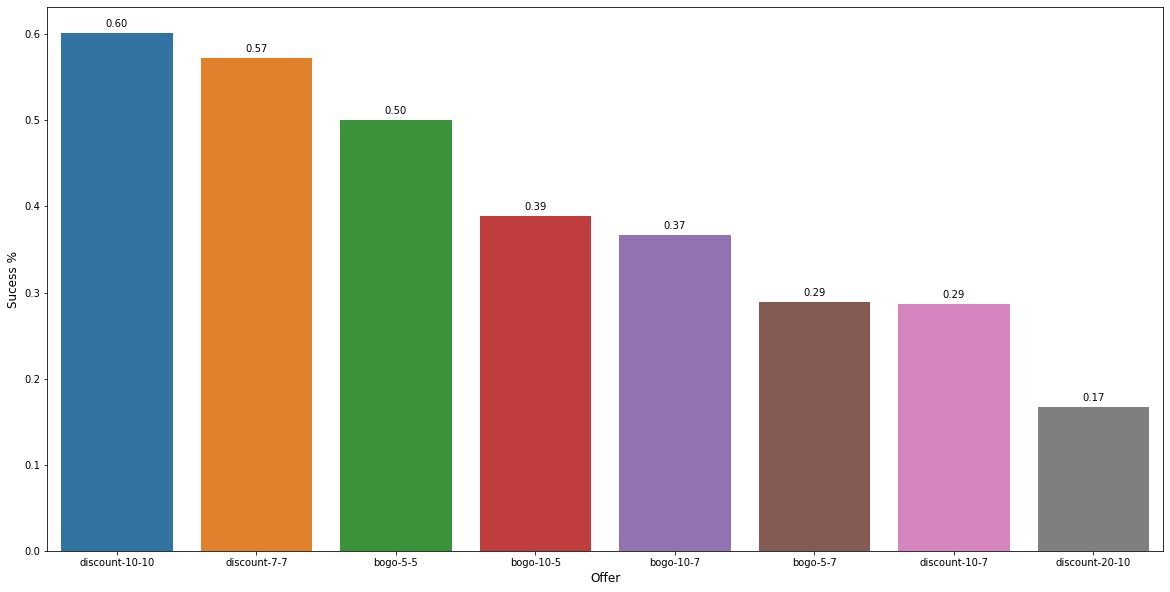

In [43]:
plt.figure(figsize=(20, 10))
splot = sns.barplot(data=offer_sucess, x='offer_id', y='sucess' ,ci=False)
plt.ylabel('Sucess %', fontsize=12)
plt.xlabel('Offer', fontsize=12)

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.savefig('./figures/offer_sucess.png')

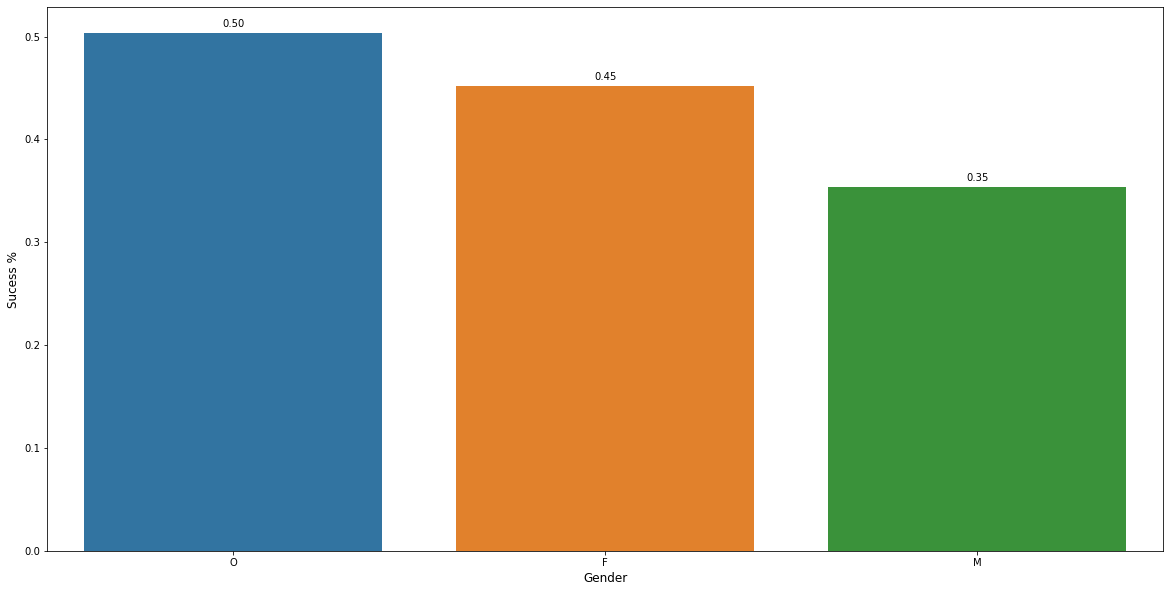

In [44]:
plt.figure(figsize=(20, 10))
splot = sns.barplot(data=gender_sucess, x='gender', y='sucess' ,ci=False)
plt.ylabel('Sucess %', fontsize=12)
plt.xlabel('Gender', fontsize=12)

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.savefig('./figures/gender_sucess.png')

# Conclusão

## Texto de conclusão